In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split

%matplotlib inline

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data preprocessing

In [32]:
df = pd.read_csv('./train.csv')
df = df.drop('Id', 1)
#df = df.drop('Name', 1)
#df = df.drop('Ticket', 1)
#df = df.drop('Cabin', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [33]:
enc_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual',
               'OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
               'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
               'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
               'SaleType','SaleCondition']
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


In [34]:
real_features = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF',
                'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                'MiscVal','MoSold','YrSold']
cat_features = list(set(df.columns.values.tolist()) - set(real_features))
cat_features.remove('SalePrice')
print (real_features)
print (cat_features)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['Functional_Min1', 'BsmtFinType1_Rec', 'Condition1_RRAn', 'Electrical_SBrkr', 'SaleType_Con', 'HeatingQC_Fa', 'Exterior1st_Wd Sdng', 'Neighborhood_Edwards', 'GarageType_Attchd', 'RoofMatl_ClyTile', 'HeatingQC_TA', 'Neighborhood_NoRidge', 'PavedDrive_Y', 'CentralAir_Y', 'PavedDrive_P', 'RoofMatl_WdShake', 'RoofStyle_Shed', 'BsmtQual_Ex', 'Condition2_Artery', 'ExterCond_Fa', 'HouseStyle_1Story', 'OverallCond_6', 'Functional_Maj2', 'ExterQual_Gd', 'SaleCondition_Normal', 'Condition1_RRNn', 'Neighborhood_SWISU', 'HouseStyle_1.5Fin', 'HeatingQC_Gd', 'Elec

In [35]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,567.240411,1057.429452,1162.626712,346.992466,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,441.866955,438.705324,386.587738,436.528436,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,808.000000,1298.250000,1391.250000,728.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [36]:
df[cat_features].describe()

,Functional_Min1,BsmtFinType1_Rec,Condition1_RRAn,Electrical_SBrkr,SaleType_Con,HeatingQC_Fa,Exterior1st_Wd Sdng,Neighborhood_Edwards,GarageType_Attchd,RoofMatl_ClyTile,...,OverallCond_2,BsmtQual_TA,LotConfig_FR3,ExterCond_Gd,Exterior1st_BrkComm,MiscFeature_Gar2,HouseStyle_2Story,OverallCond_1,Heating_GasW,SaleType_ConLw
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.021233,0.091096,0.017808,0.913699,0.001370,0.033562,0.141096,0.068493,0.595890,0.000685,...,0.003425,0.444521,0.002740,0.100000,0.001370,0.001370,0.304795,0.000685,0.012329,0.003425
std,0.144209,0.287844,0.132299,0.280905,0.036999,0.180160,0.348240,0.252677,0.490887,0.026171,...,0.058440,0.497083,0.052289,0.300103,0.036999,0.036999,0.460478,0.026171,0.110386,0.058440
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
print (df.shape)

(1460, 320)


In [38]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)

In [39]:
y = df['SalePrice'].to_numpy()
df = df.drop('SalePrice', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [6.500e+01 8.450e+03 2.003e+03 2.003e+03 1.960e+02 7.060e+02 1.500e+02
 8.560e+02 8.560e+02 8.540e+02 0.000e+00 1.710e+03 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 3.000e+00 1.000e+00 8.000e+00 0.000e+00 2.003e+03
 2.000e+00 5.480e+02 0.000e+00 6.100e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e+00 2.008e+03] 
X_cat: [0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0] 
y: 208500 


In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_real)

In [41]:
print (X_real_scaled.shape)
print (X_cat.shape)
print (y.shape)

(1460, 32)
(1460, 287)
(1460,)


In [42]:
(X_train_real, X_test_real, X_train_cat, X_test_cat, 
 y_train, y_test) = train_test_split(X_real_scaled, X_cat, y, test_size=0.3, random_state=0)
print (X_train_real.shape, X_test_real.shape)
print (X_train_cat.shape, X_test_cat.shape)

print (y_train.shape, y_test.shape)

(1022, 32) (438, 32)
(1022, 287) (438, 287)
(1022,) (438,)


In [44]:
X_train = np.hstack((X_train_real, X_train_cat))
X_test = np.hstack((X_test_real, X_test_cat))

## Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

/Users/aleksey/anaconda3/envs/learning/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [15]:
def plot_scores(optimizer):
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

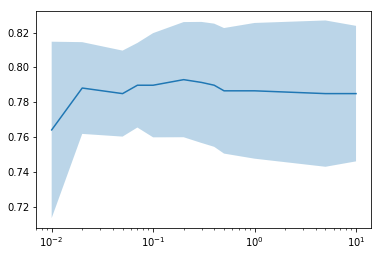

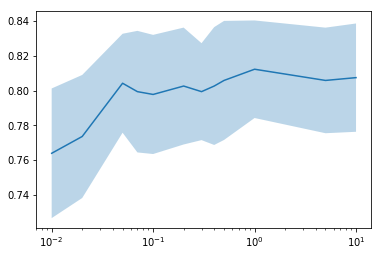

auc1: 0.8527380952380953 auc2: 0.8520833333333333


In [16]:
param_grid = {'C': [0.01, 0.02, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10]}
cv = 5

estimator = LogisticRegression('l2')

optimizer_zeros = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_zeros.fit(X_train_zeros, y_train)
plot_scores(optimizer_zeros)

predicted_zeros = optimizer_zeros.predict_proba(X_test_zeros)
auc1 = roc_auc_score(y_test, predicted_zeros[:,1])

optimizer_mean = GridSearchCV(estimator, param_grid, cv=cv)
optimizer_mean.fit(X_train_mean, y_train)
plot_scores(optimizer_mean)

predicted_mean = optimizer_mean.predict_proba(X_test_mean)
auc2 = roc_auc_score(y_test, predicted_mean[:,1])

print("auc1: {} auc2: {}".format(auc1, auc2))

### Balancing classes

In [17]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

381
242


In [18]:
X_train = X_train_zeros
X_test = X_test_zeros

X_train: (623, 24) y_train: (623, 1)
X_train_add: (139, 24) y_train_add: (139, 1)
X_train_added: (762, 24) y_train_added: (762,)


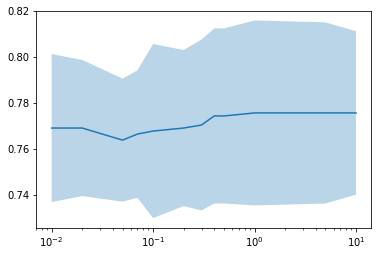

auc2: 0.8527380952380953 


In [19]:
np.random.seed(0)
y_1 = y_train[y_train==1]
y_0 = y_train[y_train==0]
indices_to_add = np.random.randint(y_1.size, size = y_0.size - y_1.size) 

X_train_to_add = X_train[y_train == 1,:][indices_to_add,:]
y_train_to_add = np.ones(X_train_to_add.shape[0])
print ("X_train: {} y_train: {}".format(X_train.shape, y_train.reshape(-1, 1).shape))
print ("X_train_add: {} y_train_add: {}".format(X_train_to_add.shape, y_train_to_add.reshape(-1, 1).shape))

X_train_added = np.vstack((X_train, X_train_to_add))
y_train_added = np.vstack((y_train.reshape(-1, 1), y_train_to_add.reshape(-1, 1))).reshape(-1)
print ("X_train_added: {} y_train_added: {}".format(X_train_added.shape, y_train_added.shape))

estimator = LogisticRegression('l2')

optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_added, y_train_added)
plot_scores(optimizer)

predicted = optimizer.predict_proba(X_test)
auc2 = roc_auc_score(y_test, predicted[:,1])

print("auc2: {} ".format(auc2))

### Selecting features with Lasso

X_train: (623, 24) X_test: (268, 24)


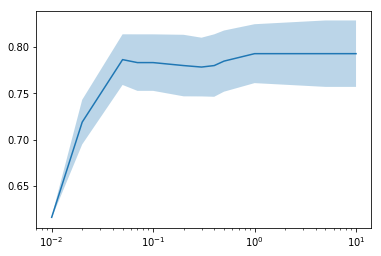

[[-0.26998855  0.18436973 -0.24995333  0.          0.          0.29017005
   0.         -0.70200734  0.          0.93249644 -0.0320982   0.
   0.74903424  0.          0.48730869  0.          0.1861887   0.16410231
  -1.6211723  -0.01401809  0.         -1.23208303  0.63111239  0.        ]]
[]
auc: 0.8496028243601059 


In [41]:
(X_train_real_zeros,  X_test_real_zeros, y_train, y_test) = train_test_split(X_real_zeros, y, test_size=0.3, random_state=0, stratify=y)
(X_train_cat_zeros, X_test_cat_zeros) = train_test_split(X_cat_zeros, test_size=0.3, random_state=0, stratify=y)

scaler = StandardScaler()
X_train_real_zeros_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_zeros_scaled = scaler.fit_transform(X_test_real_zeros)

X_train = np.hstack((X_train_real_zeros_scaled, X_train_cat_zeros))
X_test = np.hstack((X_test_real_zeros_scaled, X_test_cat_zeros))

estimator = LogisticRegression('l1', C=10.0)

print ("X_train: {} X_test: {}".format(X_train.shape, X_test.shape))


optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train, y_train)
plot_scores(optimizer)

print (optimizer.best_estimator_.coef_)

c = 0
null_idx = []
for cf in optimizer_zeros.best_estimator_.coef_[0][:24]:
    if cf == 0:
        null_idx.append(c)
    c += 1
print (null_idx)    



predicted_zeros = optimizer_zeros.predict_proba(X_test)
auc = roc_auc_score(y_test, predicted_zeros[:,1])

print("auc: {} ".format(auc))

In [42]:
selected_features = (0, 1, 2, 5, 7, 9, 10, 12, 14, 16, 17, 18, 19, 21, 22)

X_train_selected: (762, 15) y_train_selected: (762,)


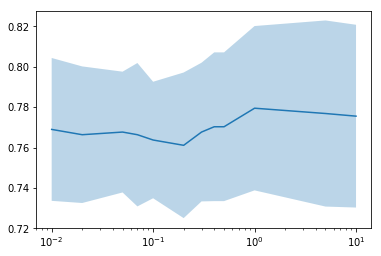

auc2: 0.8523095027949397 


In [46]:
X_train_selected = X_train_added[:,selected_features]
X_test_selected = X_test[:,selected_features]
print ("X_train_selected: {} y_train_selected: {}".format(X_train_selected.shape, y_train_added.shape))

estimator = LogisticRegression('l2')

optimizer = GridSearchCV(estimator, param_grid, cv=cv)
optimizer.fit(X_train_selected, y_train_added)
plot_scores(optimizer)

predicted = optimizer.predict_proba(X_test_selected)
auc2 = roc_auc_score(y_test, predicted[:,1])

print("auc2: {} ".format(auc2))

### LR submission

In [109]:
df = pd.read_csv('./test.csv')
passenger_ids = df['PassengerId'].to_numpy()
df = df.drop('PassengerId', 1)
df = df.drop('Name', 1)
df = df.drop('Ticket', 1)
df = df.drop('Cabin', 1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [110]:
encode_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for enc in encode_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,47.0,7.0000,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,62.0,9.6875,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,27.0,8.6625,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,22.0,12.2875,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [111]:
df.describe()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Parch_9,Embarked_C,Embarked_Q,Embarked_S
count,332.000000,417.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,...,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,30.272590,35.627188,0.255981,0.222488,0.521531,0.363636,0.636364,0.677033,0.263158,0.033493,...,0.124402,0.078947,0.007177,0.004785,0.002392,0.002392,0.004785,0.244019,0.110048,0.645933
std,14.181209,55.907576,0.436934,0.416416,0.500135,0.481622,0.481622,0.468170,0.440875,0.180135,...,0.330435,0.269980,0.084514,0.069088,0.048912,0.048912,0.069088,0.430019,0.313324,0.478803
min,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,39.000000,31.500000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,76.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [112]:
df['Age'] = df['Age'].fillna(0)
df['Fare'] = df['Fare'].fillna(0)

In [113]:
X_testing_real_zeros = df[real_features].to_numpy()
X_testing_cat_zeros = df[cat_features].to_numpy()

X_testing_real_zeros_scaled = scaler_zeros.transform(X_testing_real_zeros)

print ("X_real: {} ".format(X_real_zeros[0]))
print ("X_cat: {} ".format(X_cat_zeros[0]))
print ("y: {} ".format(y[0]))

X_real: [34.5     7.8292] 
X_cat: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0] 
y: 0 


In [114]:
print (df.shape)

(418, 25)


In [115]:
X_testing = np.hstack((X_testing_real_zeros_scaled, X_testing_cat_zeros))
X_testing = X_testing[:,selected_features]

predicted = optimizer.predict(X_testing)
print (predicted)
print (passenger_ids)

[0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0.

In [116]:
with open("submission_lr.txt", "w") as fout:
    fout.write("PassengerId,Survived\n")
    for val in zip(passenger_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))